In [122]:
import numpy as np
import math
from scipy.linalg import lstsq
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [163]:
# Signal and channel parameters
Fs = 100000    # Sampling frequency
Fc = 2e9       # Carrier frequency
Fd = 100*(100/Fs)       # Doppler frequency (used for SNR analysis)
Tc = 1 / (10 * Fd)  # Coherence time based on Doppler frequency
N = 100000     # Number of data points in the signal
packet_size = math.floor(Fs * Tc)//5  # Size of each packet
header_packet_size = math.floor((1 / 6) * packet_size)  # Known part of the signal (header)
epsilon = 1e-10  # Small constant to avoid division by zero


In [165]:
# Generate BPSK signal
def generate_bpsk_signal(N):
    bits = np.random.randint(0, 2, N)
    return 2 * bits - 1  # BPSK mapping: 0 -> -1, 1 -> 1

In [167]:
# Sum-of-sines model for Rayleigh fading channel
def sum_of_sines_model(N, Fd, Fs):
    t = np.arange(N) / Fs
    num_sines = 8  # Number of sinusoids
    # Jakes' model Doppler shifts
    doppler_shift = Fd * np.cos(2 * np.pi * np.arange(1, num_sines + 1) / (2 * num_sines + 1))
    phases = np.random.uniform(0, 2 * np.pi, num_sines)
    channel = np.zeros(N, dtype=complex)
    
    for i in range(num_sines):
        channel += np.exp(1j * (2 * np.pi * doppler_shift[i] * t + phases[i]))
    
    channel /= np.sqrt(num_sines)  # Normalize power
    return channel

In [169]:
# Add noise to the signal based on SNR
def add_noise(signal, snr_db):
    snr_linear = 10**(snr_db / 10)
    signal_power = np.mean(np.abs(signal)**2)
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power / 2) * (
        np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape)
    )
    return signal + noise

# Compute BER
def compute_ber(original_bits, estimated_bits):
    errors = np.sum(original_bits != estimated_bits)
    return errors / len(original_bits)

# BPSK demodulation
def bpsk_demodulate(signal):
    return np.where(np.real(signal) >= 0, 1, -1)

In [171]:
# Main function to calculate BER and MSE assuming constant channel over packets
def calculate_ber_mse(N, Fs, packet_size, header_packet_size, snr_db_range, doppler_freq_range):
    signal = generate_bpsk_signal(N)  # Generate BPSK signal
    num_packets = N // packet_size     # Number of packets

    # Arrays to store results
    ber_snr = []
    mse_snr = []
    ber_doppler = []
    mse_doppler = []

    # BER and MSE vs SNR
    Fd_fixed = 100  # Fixed Doppler frequency for SNR analysis
    for snr_db in snr_db_range:
        total_ber = 0
        total_mse = 0
        total_bits = 0
        total_header_bits = 0

        for packet_idx in range(num_packets):
            # Generate a constant channel for this packet
            channel = sum_of_sines_model(1, Fd_fixed, Fs)[0]
            packet_channel = np.full(packet_size, channel)

            # Get the current packet of signal
            packet_start = packet_idx * packet_size
            packet_end = packet_start + packet_size
            packet_signal = signal[packet_start:packet_end]

            # Transmit signal through channel
            transmitted_signal = packet_signal * packet_channel

            # Add noise
            noisy_signal = add_noise(transmitted_signal, snr_db)

            # Known header parts
            header_transmitted = packet_signal[:header_packet_size]
            header_noisy = noisy_signal[:header_packet_size]

            # Perform least squares estimation to estimate the channel
            channel_estimated, _, _, _ = lstsq(header_transmitted.reshape(-1, 1), header_noisy)
            channel_estimated = channel_estimated[0]

            # Equalization for the entire packet
            equalized_signal = noisy_signal / channel_estimated

            # BPSK demodulation
            demodulated_signal = bpsk_demodulate(equalized_signal)

            # Compute BER for the packet (excluding header)
            original_bits = packet_signal[header_packet_size:]
            estimated_bits = demodulated_signal[header_packet_size:]
            ber = compute_ber(original_bits, estimated_bits)

            # Compute MSE for the header (using complex values)
            true_channel = packet_channel[:header_packet_size]
            estimated_channel = np.full(header_packet_size, channel_estimated)
            mse = np.mean(np.abs(true_channel - estimated_channel)**2)

            # Update total counts
            total_ber += ber * len(original_bits)
            total_mse += mse * header_packet_size
            total_bits += len(original_bits)
            total_header_bits += header_packet_size

        # Store average BER and MSE for this SNR
        ber_snr.append(total_ber / total_bits)
        mse_snr.append(total_mse / total_header_bits)

    # BER and MSE vs Doppler Frequency
    snr_db_fixed = 10  # Fixed SNR for Doppler analysis
    for Fd in doppler_freq_range:
        total_ber = 0
        total_mse = 0
        total_bits = 0
        total_header_bits = 0

        for packet_idx in range(num_packets):
            # Generate a constant channel for this packet
            channel = sum_of_sines_model(1, Fd, Fs)[0]
            packet_channel = np.full(packet_size, channel)

            # Get the current packet of signal
            packet_start = packet_idx * packet_size
            packet_end = packet_start + packet_size
            packet_signal = signal[packet_start:packet_end]

            # Transmit signal through channel
            transmitted_signal = packet_signal * packet_channel

            # Add noise
            noisy_signal = add_noise(transmitted_signal, snr_db_fixed)

            # Known header parts
            header_transmitted = packet_signal[:header_packet_size]
            header_noisy = noisy_signal[:header_packet_size]

            # Perform least squares estimation to estimate the channel
            channel_estimated, _, _, _ = lstsq(header_transmitted.reshape(-1, 1), header_noisy)
            channel_estimated = channel_estimated[0]

            # Equalization for the entire packet
            equalized_signal = noisy_signal / channel_estimated

            # BPSK demodulation
            demodulated_signal = bpsk_demodulate(equalized_signal)

            # Compute BER for the packet (excluding header)
            original_bits = packet_signal[header_packet_size:]
            estimated_bits = demodulated_signal[header_packet_size:]
            ber = compute_ber(original_bits, estimated_bits)

            # Compute MSE for the header (using complex values)
            true_channel = packet_channel[:header_packet_size]
            estimated_channel = np.full(header_packet_size, channel_estimated)
            mse = np.mean(np.abs(true_channel - estimated_channel)**2)

            # Update total counts
            total_ber += ber * len(original_bits)
            total_mse += mse * header_packet_size
            total_bits += len(original_bits)
            total_header_bits += header_packet_size

        # Store average BER and MSE for this Doppler frequency
        ber_doppler.append(total_ber / total_bits)
        mse_doppler.append(total_mse / total_header_bits)

    return ber_snr, mse_snr, ber_doppler, mse_doppler


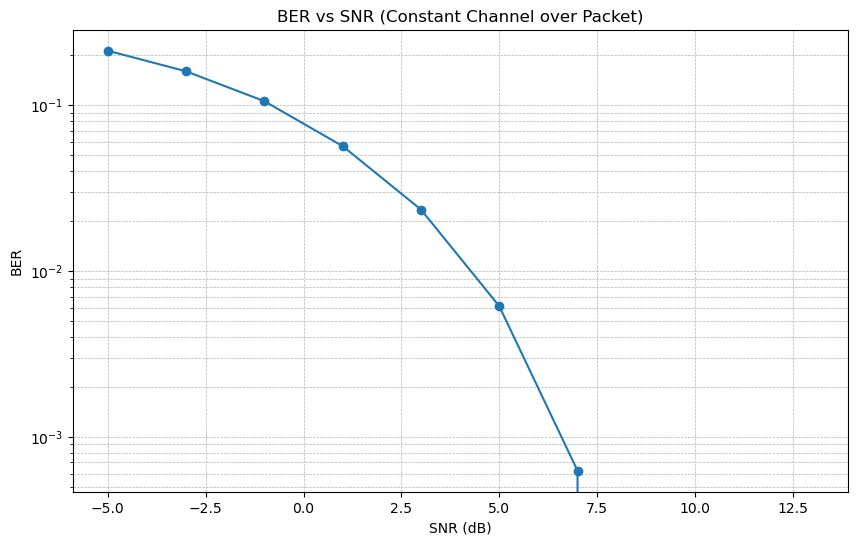

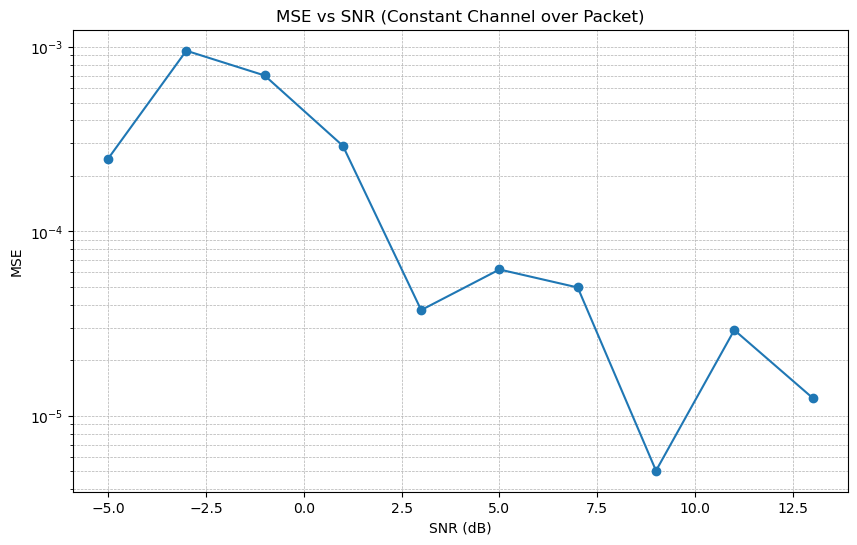

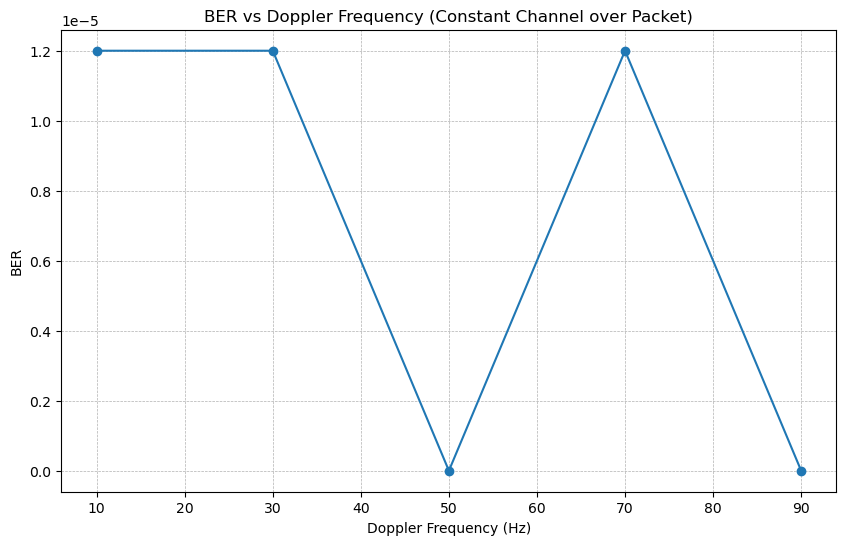

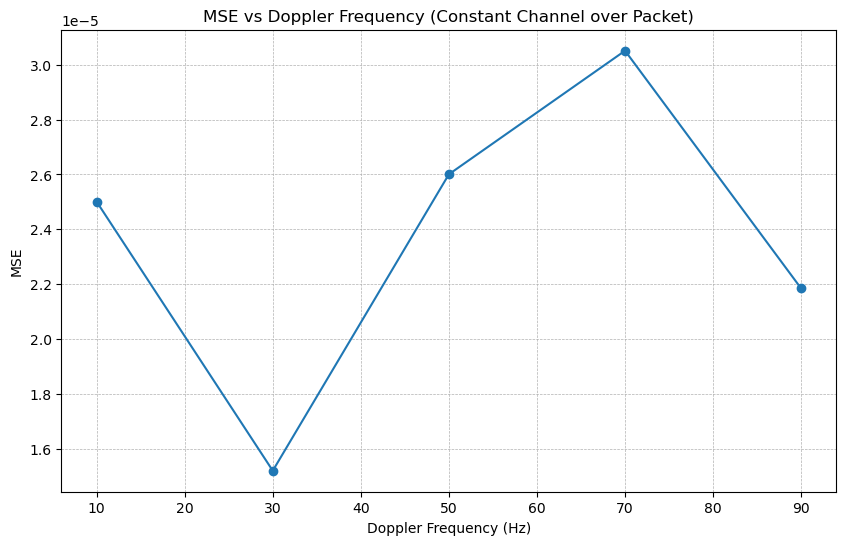

In [173]:
# Define SNR and Doppler frequency ranges
snr_db_range = np.arange(-5, 15, 2)  # From -5 dB to 13 dB in steps of 2 dB
doppler_freq_range = np.arange(10, 110, 20)  # From 10 Hz to 90 Hz in steps of 20 Hz

# Call the function to get BER and MSE values
ber_snr, mse_snr, ber_doppler, mse_doppler = calculate_ber_mse(
    N=N,
    Fs=Fs,
    packet_size=packet_size,
    header_packet_size=header_packet_size,
    snr_db_range=snr_db_range,
    doppler_freq_range=doppler_freq_range
)

# Plot BER vs SNR
plt.figure(figsize=(10, 6))
plt.semilogy(snr_db_range, ber_snr, marker='o')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.title('BER vs SNR (Constant Channel over Packet)')
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=12))
plt.show()

# Plot MSE vs SNR
plt.figure(figsize=(10, 6))
plt.semilogy(snr_db_range, mse_snr, marker='o')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('SNR (dB)')
plt.ylabel('MSE')
plt.title('MSE vs SNR (Constant Channel over Packet)')
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=12))
plt.show()

# Plot BER vs Doppler Frequency
plt.figure(figsize=(10, 6))
plt.plot(doppler_freq_range, ber_doppler, marker='o')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xlabel('Doppler Frequency (Hz)')
plt.ylabel('BER')
plt.title('BER vs Doppler Frequency (Constant Channel over Packet)')
plt.show()

# Plot MSE vs Doppler Frequency
plt.figure(figsize=(10, 6))
plt.plot(doppler_freq_range, mse_doppler, marker='o')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xlabel('Doppler Frequency (Hz)')
plt.ylabel('MSE')
plt.title('MSE vs Doppler Frequency (Constant Channel over Packet)')
plt.show()